### Introduction :

Ce notebook vise à developper le suivi d'un developpement ML avec l'outil MLFLOW pour une application de "credit_scoring". Détecter les demandeurs de crédit présentant une forte probabilité d'être défaillant.  
Nous allons au cours de ce notebook developper un pipeline ML avec un modèle de base : regression logistique.
Nous aurons tour à tour: 
1. le prétraitement des données.
2. Modélisation et le suivi du modèle et ses artéfacts sur mlflow
3. indice du rendu métier.

 ### Méthode 
1. Préprocessing
2. Dev ML  avec la table application (train et test).
3. développement coût et seuil probabliste de promotion 


In [42]:
#%% import les bibliothèques
import pandas as pd
import numpy as np
import gc # Pour la gestion de la mémoire
import os ,re
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import mlflow

#%% importer les tables 
len(os.listdir("./data"))

9

Importation des tables applications -- train & test ---  
Ce sont les tables principales par lesquelles nous allons débuter notre developpement ainsi :  
1. Sélection  de features
Nous allons selectionner un nombre réduit de variables grâce la propriété de "variable importance" de lightgbm
2. Construction de variable 
Nous enrichirons nos données avec des features composées ou celles des tables supplémentaires dans d'autres notebook.


In [43]:
# table application 
import pandas as pd
import numpy as np

# Chargement
train = pd.read_csv('./data/application_train.csv')
test = pd.read_csv('./data/application_test.csv')

# Anomalie classique : 365243 jours d'emploi (~1000 ans)
# On remplace par NaN pour que l'imputer s'en occupe proprement
train.replace({'DAYS_EMPLOYED':365243}, np.nan, inplace=True)
test.replace({'DAYS_EMPLOYED':365243}, np.nan, inplace=True)

# Sauvegarde des IDs et de la Target
train_labels = train['TARGET']
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

# Alignement des colonnes (One-Hot Encoding)
train.drop(columns=train.columns[train.columns.str.contains('_ID_',regex=False)], inplace=True)
test.drop(columns=test.columns[test.columns.str.contains('_ID_',regex=False)], inplace=True)  
#train = pd.get_dummies(train.drop(columns=['TARGET']))
#test = pd.get_dummies(test)

# On s'assure que les deux tableaux ont les mêmes colonnes
train, test = train.align(test, join='inner', axis=1)

print(f"Structure prête : {train.shape[1]} variables conservées.")
train.shape
test.shape
### Inspection des données 


Structure prête : 119 variables conservées.


(48744, 119)


Vu le grand nombre de features on va se servir de lightgbm pour avoir une idée de leur importance. D'un autre côté lightgbm peut gérer des données contenant des variables catégorielles non-encodées.


In [44]:
#--- Fonction d'analyse de l'importance des variables ---
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(X, y,n_features=10):
    """
    Entraînement d'un modèle rapide (LightGBM est idéal pour ça) On utilise class_weight='balanced' pour gérer le déséquilibre
    @Args:
        X: DataFrame des features
        y: Series de la target
    @Returns:
        importance_df: DataFrame avec l'importance des features normalisée 
    """
    # 1. impléméntaion du modèle
    model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X.select_dtypes(include=[np.number]), y)
    
    # 2. Récupération de l'importance
    importance_df = pd.DataFrame({
        'feature': X.select_dtypes(include=[np.number]).columns,
        'importance': model.feature_importances_/sum(model.feature_importances_)
    }).sort_values(by='importance', ascending=False
                   )
    
    # 3. Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(n_features), palette='magma')
    plt.title(f'Top {n_features} des variables les plus importantes (LightGBM)')
    plt.xlabel('Importance (Gain/Split)')
    plt.show()
    
    return importance_df


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10951
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


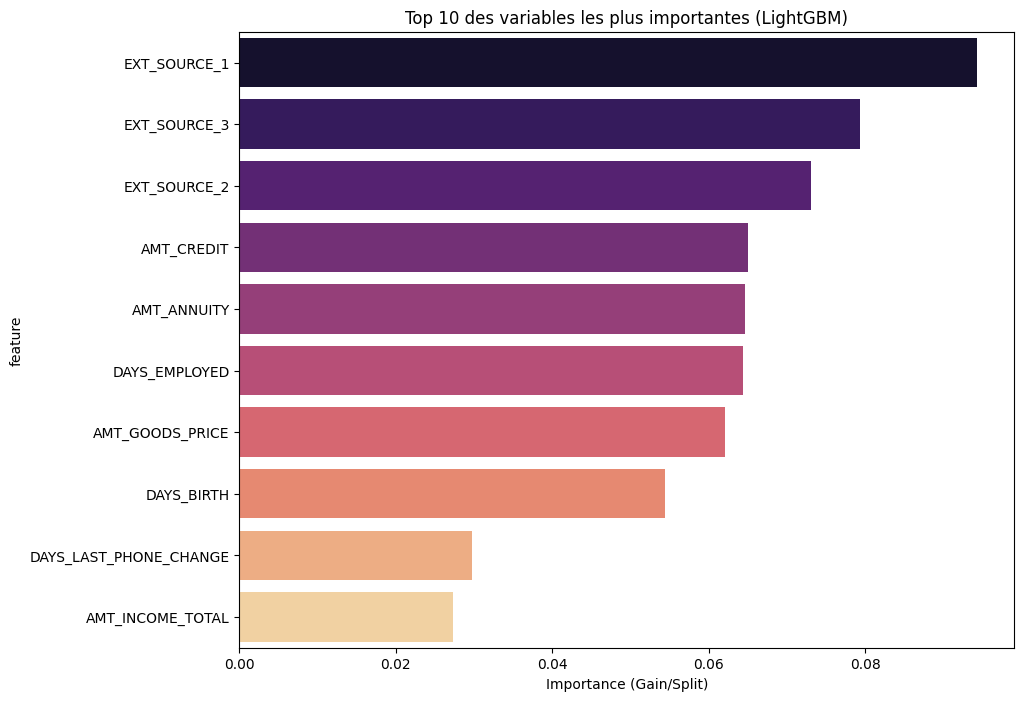

((307511, 10), (48744, 10))

In [45]:
# Plot des 20 variables les plus importantes selon un premier jet du modèle
importance_df =plot_feature_importance(train, train_labels,n_features=10)
### dataset restreint
# 1. extraction  des features
features = importance_df.feature[:10].tolist()

# 2. nouveaux train et test
train_selected = train[features]
test_selected = test[features]  

train_2ag = train_selected.copy()
test_2ag = test_selected.copy()



# dimensions des datasets sélectionnés
train_selected.shape, test_selected.shape


 
On obtient 2 tables de 20 features chacune de plus 48 000 lignes.

 
#### Valeurs manquantes :

In [46]:
 
#recherche de features ayant plus de 90% de valeurs manquantes 

print(f"Nombre de variables avec plus de 90% de valeurs manquantes :  {(train_selected.isnull().mean()>=0.9).sum()}")
# existence de variables catégorielles
cat_col = train_selected.select_dtypes(include=['object']).columns.tolist()
len(cat_col)


Nombre de variables avec plus de 90% de valeurs manquantes :  0


0


Pas de feature catégorielle dans la table de données...


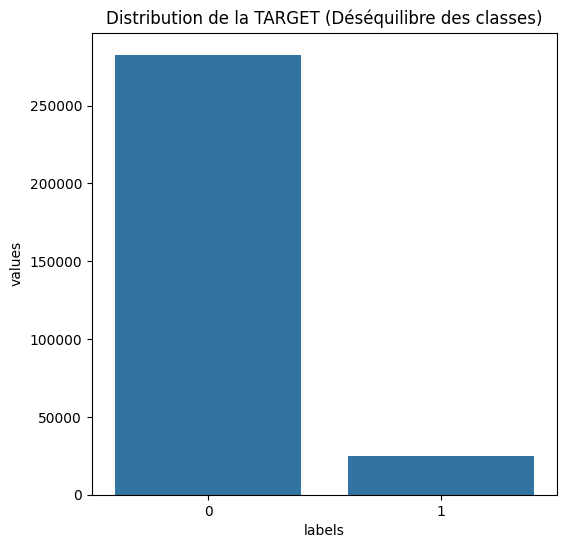

Ratio de la classe minoritaire : 8.07%


['preprocessor.pkl']

In [47]:

#### viz de la feature TARGET
import matplotlib.pyplot as plt
import seaborn as sns

temp =train_labels.value_counts()
df_temp = pd.DataFrame({'labels': temp.index, 'values': temp.values})

plt.figure(figsize = (6,6))
plt.title('Distribution de la TARGET (Déséquilibre des classes)')
sns.barplot(x = 'labels', y = 'values', data=df_temp)
plt.show()

print(f"Ratio de la classe minoritaire : {100 * temp[1]/(temp[0]+temp[1]):.2f}%")
# on retient les colonnes selectionnées et on ajoute TARGET
#train_selected = pd.concat([train_selected, train_labels], axis=1)
# train selected shape
train_selected.shape
# Prétraitement et sauvegarde des datasets  
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import joblib


# 1. Pipeline de Preprocessing
# Median est plus robuste aux outliers que Mean pour ce dataset
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

# 2. Application
train_array= preprocessor.fit_transform(train_selected)
#X_val_final = preprocessor.transform(X_val)
test_array = preprocessor.transform(test_selected)

# 3. Reconversion en DataFrame
train_selected= pd.DataFrame(train_array, columns=train_selected.columns)
#train_selected['TARGET'] = train_labels.values
test_selected = pd.DataFrame(test_array, columns=test_selected.columns)



# Sauvegarde pour le Dashboard (Etape 3)
joblib.dump(preprocessor, 'preprocessor.pkl')

In [48]:
#missing values 
train_selected.isnull().mean().mean()*100

np.float64(0.0)

 
### features inspection and cleaning 
Nous allons faire une analyse de corrélation avec la variable cible et supprimer les variables corrélées à TARGET pour l'instant.


Nombre de colonnes avec une corrélation > 0.9: 1
Exemples de colonnes supprimées : ['AMT_GOODS_PRICE']
Nouveau nombre de variables : 9


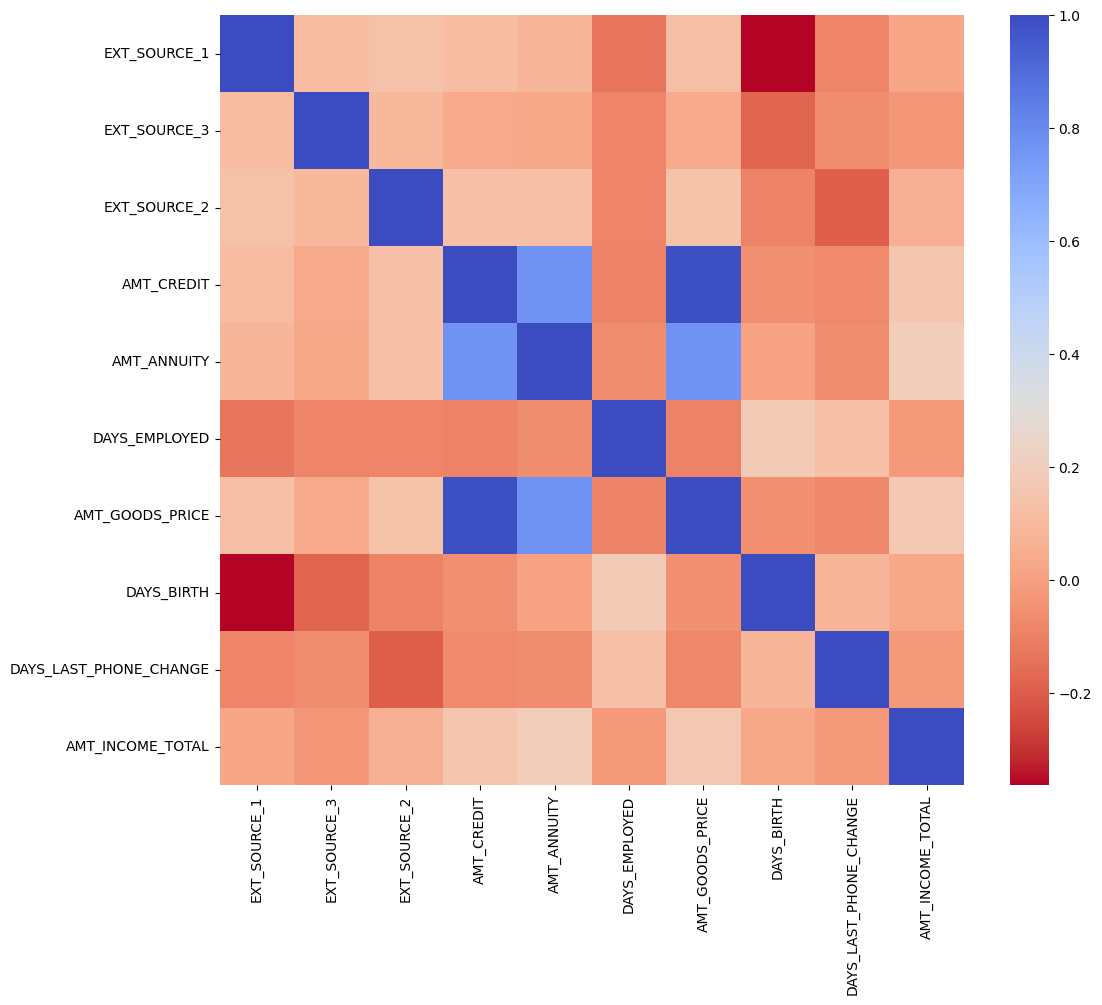

<Figure size 600x400 with 0 Axes>

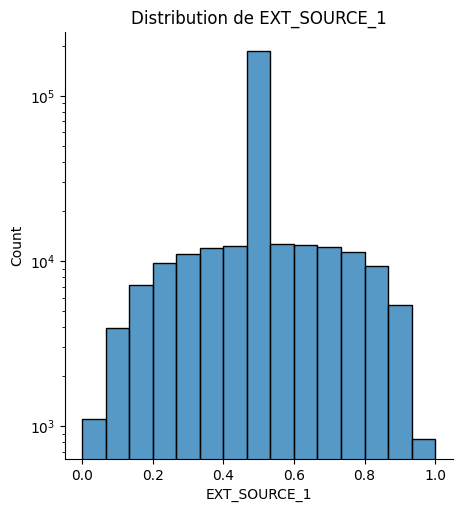

<Figure size 600x400 with 0 Axes>

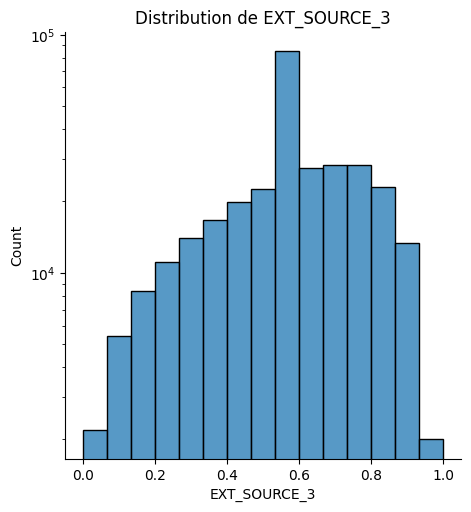

<Figure size 600x400 with 0 Axes>

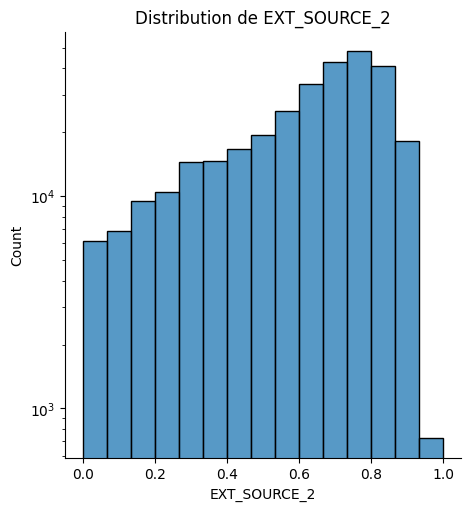

<Figure size 600x400 with 0 Axes>

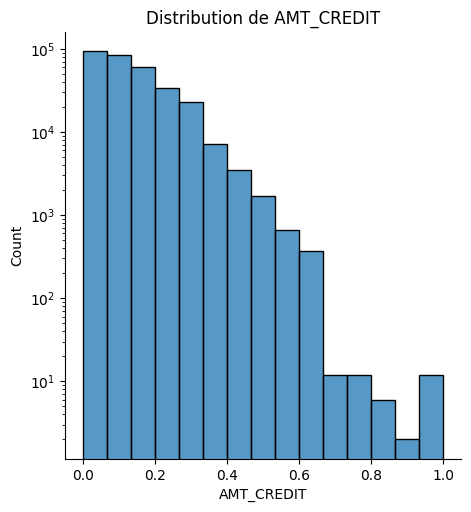

<Figure size 600x400 with 0 Axes>

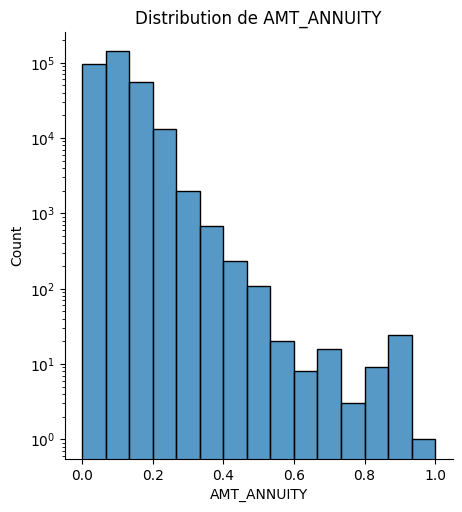

<Figure size 600x400 with 0 Axes>

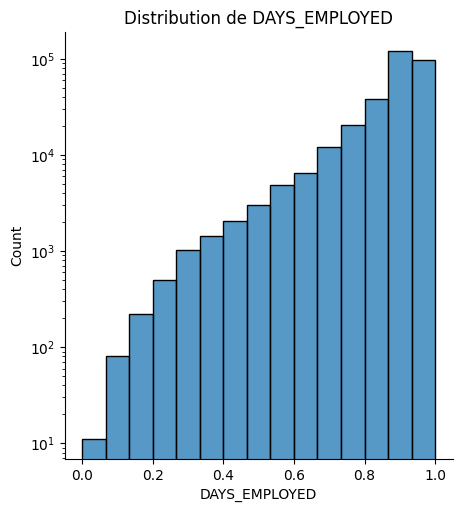

<Figure size 600x400 with 0 Axes>

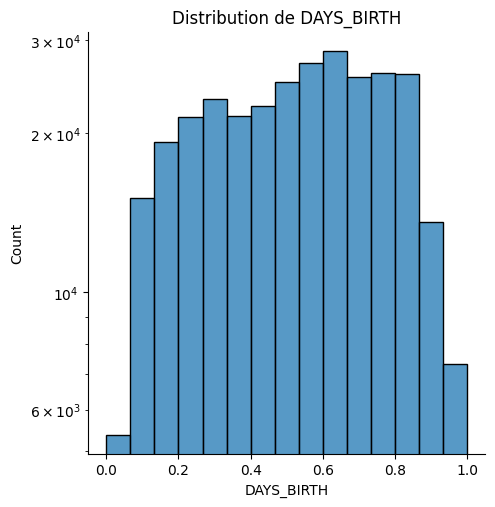

<Figure size 600x400 with 0 Axes>

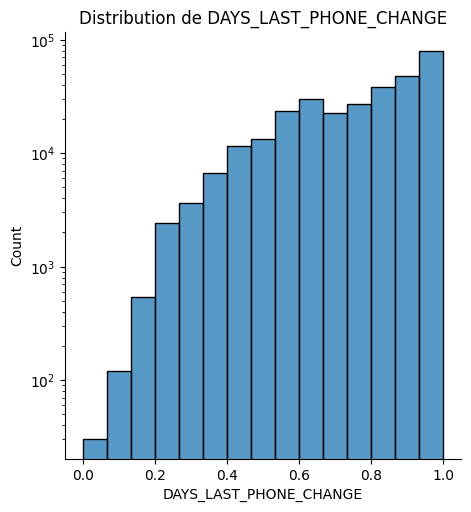

<Figure size 600x400 with 0 Axes>

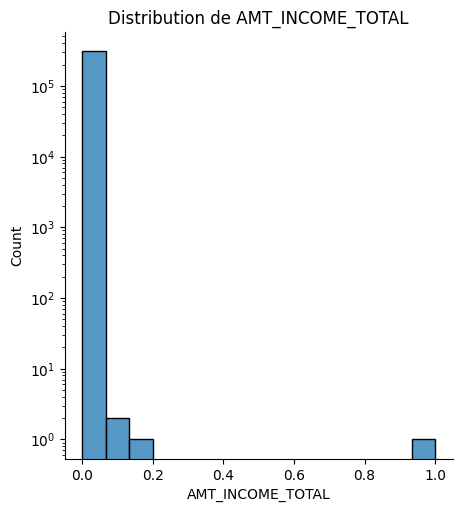

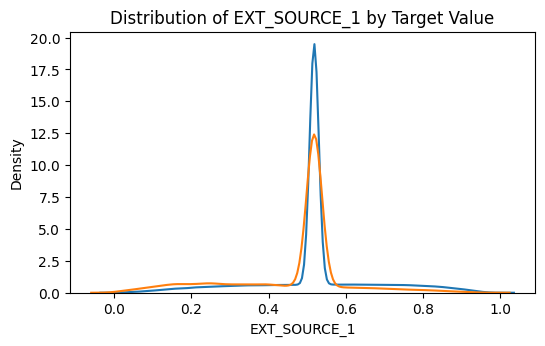

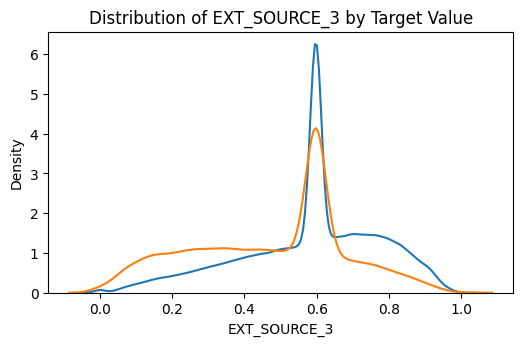

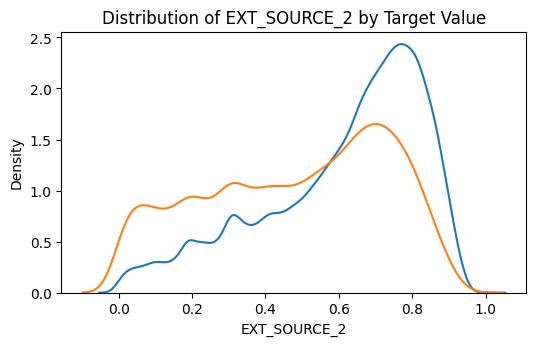

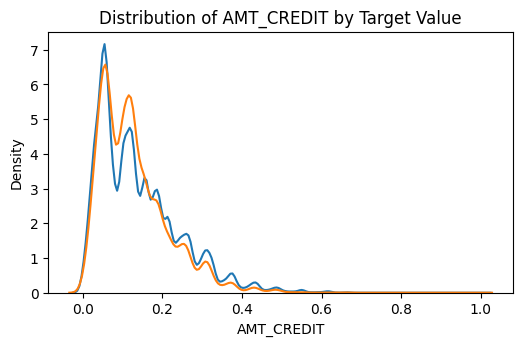

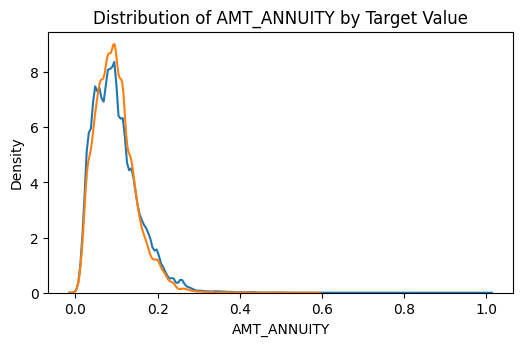

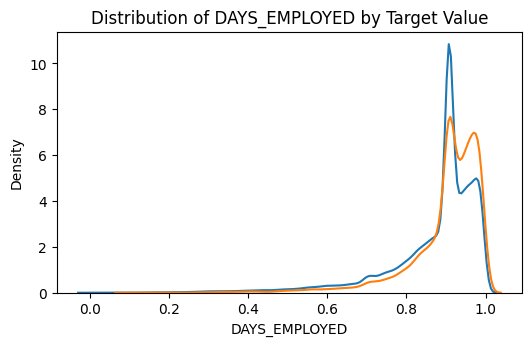

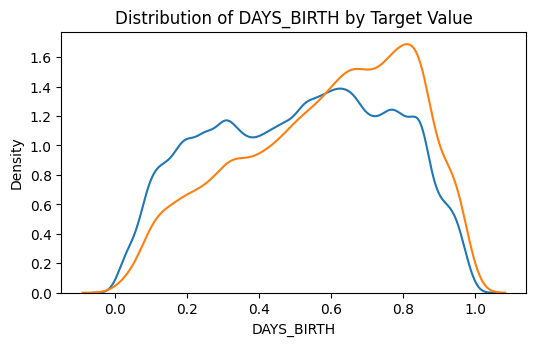

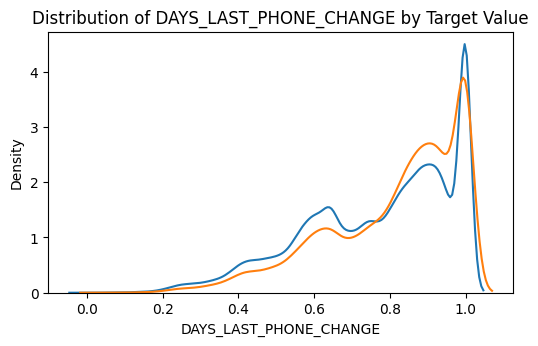

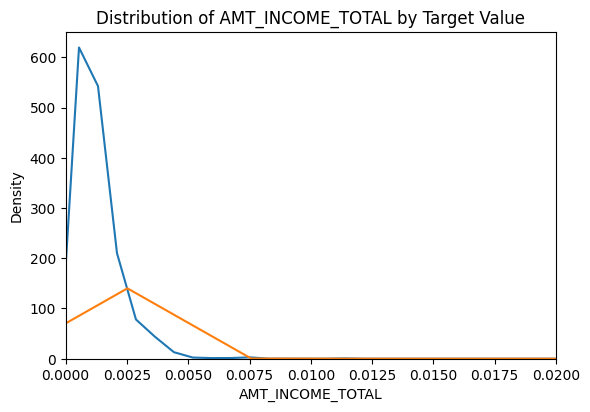

In [49]:
# correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns       
corr = train_selected.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 8}) 

corr_df = pd.DataFrame(np.triu(corr, k=1), columns=corr.columns, index=corr.index)
#supprime les variables aux corrélations élevées
def remove_highly_correlated_features(df, threshold=0.9):
    # On ne calcule la corrélation que sur les variables explicatives (pas la TARGET)
    df_features = df.drop(columns=['TARGET']) if 'TARGET' in df.columns else df
    
    # Calcul de la matrice de corrélation
    corr_matrix = df_features.select_dtypes(include=[np.number]).corr().abs()
    
    # Sélection du triangle supérieur de la matrice (pour éviter les doublons A-B et B-A)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identification des colonnes à supprimer
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Nombre de colonnes avec une corrélation > {threshold}: {len(to_drop)}")
    print(f"Exemples de colonnes supprimées : {to_drop[:10]}")
    
    df_reduced = df.drop(columns=to_drop)
    print(f"Nouveau nombre de variables : {df_reduced.shape[1]}")
    
    return df_reduced


# Utilisation avec un seuil de 0.9 (90% de corrélation)
train_selected = remove_highly_correlated_features(train_selected, threshold=0.9)

### EDA 
train_selected.columns .tolist()
#1D EDA 

for feature in train_selected.columns.to_list():
    plt.figure(figsize=(6,4))
    #plt.subplot(len(train_selected.columns),1)
    sns.displot(train_selected[feature],kind='hist',bins=15)
    plt.title(f'Distribution de {feature}')
    plt.yscale('log')
    plt.show()
   
# 2D EDA - Analyse bivariée
train_selected['TARGET'] = train_labels
import matplotlib.pyplot as plt
#plt.figure(figsize = (12, 12))
# iterate through the new features
for i, feature in enumerate(train_selected.columns[:-1]):
    plt.figure(figsize = (6, 40))
    # create a new subplot for each source
    plt.subplot(len(train_selected.columns), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_selected.loc[train_selected['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_selected.loc[train_selected['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    if feature == "AMT_INCOME_TOTAL":
        plt.xlim((0.0,0.02))
    
plt.tight_layout(h_pad = 2.5)


In [50]:

### Modélisation
# nettoie les noms des variables 
import re

def clean_column_names(df):
    # Cette regex remplace tout caractère non-alphanumérique par un underscore
    df.columns = [re.sub(r'[^\w\s]', '_', col) for col in df.columns]
    # Remplace aussi les espaces par des underscores
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

#dataset_final.dropna(inplace = True,axis=0)


In [51]:

# Appliquez le nettoyage sur vos données d'entraînement
train_selected = clean_column_names(train_selected)
test = clean_column_names(test)
y = train_selected.TARGET
X = train_selected.drop('TARGET',axis=1)
# 4. Split Train / Validation
X = train_selected.drop(columns=['TARGET'], errors='ignore')
y = train_labels
# split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



=== ML train : MLFLOW === 


In [52]:

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((246008, 9), (61503, 9), (246008,), (61503,))

In [53]:

# On insere les contraintes métier
import numpy as np
from sklearn.metrics import confusion_matrix 

def optimize_threshold(y_true, y_probs):
    """
    Trouve le seuil qui minimise le coût métier : (10 * FN) + (1 * FP).
    
   @Args:
         y_true : les vraies étiquettes (0 ou 1)
        y_probs : les probabilités prédites par le modèle (pour la classe 1)
    @returns :
        best_treshold , min_cost
    """
    thresholds = np.linspace(0, 1, 101)  # Teste 100 seuils de 0.0 à 1.0
    costs = []
    
    for thr in thresholds:
        # On transforme la probabilité en prédiction binaire selon le seuil
        y_pred = (y_probs >= thr).astype(int)
        
        # Calcul de la matrice de confusion
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcul du coût métier (pondération 10 pour les faux négatifs)
        current_cost = (10 * fn) + (1 * fp)
        costs.append(current_cost)
    
    # Trouver l'index du coût minimum
    best_index = np.argmin(costs)
    best_threshold = thresholds[best_index]
    min_cost = costs[best_index]
    
    return best_threshold, min_cost

# Paramètres de test
params = {
    'class_weight': {0: 1, 1: 10}, 
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': 42,
    'C': 0.01
}

from sklearn.linear_model import LogisticRegression

def train_with_mlflow(X_train, y_train, X_val, y_val, params, run_name, model_obj,model_name):
    """
    cette fonction entraîne un modèle de régression logistique avec les paramètres donnés,  
    et enregistre les résultats dans MLflow.

    @Args:
        X_train: DataFrame des features d'entraînement
        y_train: Series des labels d'entraînement
        X_val: DataFrame des features de validation
        y_val: Series des labels de validation
        params: dictionnaire des hyperparamètres pour la régression logistique
        run_name: nom de la run MLflow
        model_name: nom sous lequel sauvegarder le modèle dans MLflow
    @Returns:
        None    
    """
    import mlflow 
    mlflow.end_run() # Ferme tout run resté ouvert par erreur
    
    with mlflow.start_run(run_name=run_name):
        # Entraînement
        clf = model_obj(**params)
        clf.fit(X_train, y_train)
        
        # Prédictions
        y_probs = clf.predict_proba(X_val)[:, 1]
        
        # Seuil métier et Coût
        best_thr, min_cost = optimize_threshold(y_val, y_probs)
        y_pred_opt = (y_probs >= best_thr).astype(int)
        
        # Calcul des métriques de performance
        metrics = {
            "business_score": min_cost,
            "auc": roc_auc_score(y_val, y_probs),
            "recall": recall_score(y_val, y_pred_opt),
            "precision": precision_score(y_val, y_pred_opt),
            "optimal_threshold": best_thr
        }
        
        # Logs MLflow
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        
        # Sauvegarde correcte (Modèle + Preprocessor)
        mlflow.sklearn.log_model(sk_model=clf, name=model_name,registered_model_name=model_name)
        joblib.dump(preprocessor, "preprocessor.pkl")
        mlflow.log_artifact("preprocessor.pkl")
        mlflow.sklearn.log_model(sk_model=model_obj,
                                 name=model_name,
                                 registered_model_name=model_name)

        print(f"Run {run_name} terminé.")
        print(f"Score Métier: {min_cost} | AUC: {metrics['auc']:.3f} | Recall: {metrics['recall']:.3f}")
    

In [54]:
# run name
run_name="Baseline_Model"
# 1. Nommer l'expérience pour s'y retrouver dans l'UI
mlflow.set_experiment("Credit_Scoring")
mlflow.set_tag("model_tag","logistic_regression_baseline")

# Remplacez par le chemin absolu pour être certain
mlflow.set_tracking_uri("sqlite:////Users/mpaga/Desktop/OC/Projet6/mlflow.db")

#run mlflow 
train_with_mlflow(X_train,y_train, X_val, y_val, 
                  params,
                  run_name,
                  model_obj = LogisticRegression,
                  model_name="Logistic_Regression " 
                  )



2026/02/05 09:30:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Logistic_Regression ' already exists. Creating a new version of this model...
Created version '5' of model 'Logistic_Regression '.
2026/02/05 09:30:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run Baseline_Model terminé.
Score Métier: 35270 | AUC: 0.723 | Recall: 0.630


Registered model 'Logistic_Regression ' already exists. Creating a new version of this model...
Created version '6' of model 'Logistic_Regression '.
